In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import functions as funcs
import pyemma as pm
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
import numpy as np
import functions as funcs
import pymc3 as pm
import scipy as sp
import pickle

In [43]:
def fit(data, dep_var, ind_vars, formula, input_space, bayes_kws):
    # determin min/max values for scaling function
    dep_range = np.array([data[dep_var].min(), data[dep_var].max()])    
    output_space = {'dep_var': dep_range}
    var_space = input_space.copy()
    var_space.update({dep_var: output_space['dep_var']})
    
    # Create scaler
    vs = funcs.create_grid(var_space)
    vs_y, vs_X = funcs.create_dmatrices(vs, formula=formula)
    _, scaler = funcs.scale_dmatrix(pd.concat([vs_y, vs_X], axis=1), scaler=None)

    # Scale data
    y, X = funcs.create_dmatrices(data, formula=formula)
    data_s, _ = funcs.scale_dmatrix(pd.concat([y, X], axis=1), scaler=scaler)
    # GP data and priors
    dep_var_cols = [x for x in data_s.columns if dep_var in x]
    ind_var_cols = [x for x in data_s.columns if np.any([y in x for y in ind_vars])]
    y = data_s.loc[:, dep_var_cols]
    X =  data_s.loc[:, ind_var_cols]

    l_prior = funcs.gamma(2, 0.5)
    eta_prior = funcs.hcauchy(2)
    sigma_prior = funcs.hcauchy(2)
    
    
    gp, trace, model = funcs.fit_gp(y=y, X=X,  # Data
                                    l_prior=l_prior, eta_prior=eta_prior, sigma_prior=sigma_prior,  # Priors
                                    kernel_type='m52',  # Kernel
                                    prop_Xu=None,  # proportion of data points which are inducing variables.
                                    bayes_kws=bayes_kws)  # Bayes kws

    results = {'gp': gp, 'trace': trace, 'model': model, 'data': data}
    return results


def get_data(data_sets, dep_var, ind_vars, protein, feature, num_its=None, transform=None):
    
    data = data_sets[dep_var].copy()
    ix = (data.protein==protein) & (data.feature__value==feature)
    if dep_var == 'timescale':
        ix = ix & (data.num_its == num_its)
    if feature == 'distances':
        if transform is None:
            raise ValueError('For distance feature you must specify a transform')
        ix = ix & (data.distances__transform == transform)
        
    data = data.loc[ix, [dep_var]+ind_vars]
    return data
 

# Introduction

This notebook selects the most poorly performing model (in terms of the number of divergences) and will try to diagnose and fix the problem. I will be following the advice in [this PyMC3 tutorial](https://docs.pymc.io/pymc-examples/examples/diagnostics_and_criticism/Diagnosing_biased_Inference_with_Divergences.html). 

## Find worst model

In [4]:
model_paths = Path('sensitivities_m52').glob('*.pkl')
for path in model_paths:
    result = pickle.load(path.open('rb'))
    divergent = result['trace']["diverging"]
    print(path.stem, divergent.nonzero()[0].size)

uvf_dihedrals_timescale_its_2_sensitivity 2
2f4k_distances_linear_timescale_its_2_sensitivity 0
1fme_dihedrals_timescale_its_4_sensitivity 0
1fme_distances_linear_timescale_its_3_sensitivity 40
prb_dihedrals_timescale_its_3_sensitivity 17
cln025_dihedrals_vamp_sensitivity 0
2f4k_dihedrals_vamp_sensitivity 2
2wav_distances_linear_timescale_its_3_sensitivity 11
gtt_dihedrals_timescale_its_3_sensitivity 2
gtt_dihedrals_timescale_its_4_sensitivity 1
2jof_distances_linear_vamp_sensitivity 0
1fme_distances_linear_timescale_its_4_sensitivity 20
2jof_dihedrals_timescale_its_2_sensitivity 0
1fme_dihedrals_timescale_its_3_sensitivity 14
2wav_distances_linear_vamp_sensitivity 6
2wav_dihedrals_timescale_its_2_sensitivity 34
prb_distances_linear_vamp_sensitivity 284
cln025_distances_linear_timescale_its_2_sensitivity 0
2jof_dihedrals_timescale_its_3_sensitivity 0
1fme_dihedrals_timescale_its_2_sensitivity 0
2wav_dihedrals_vamp_sensitivity 0
uvf_dihedrals_timescale_its_4_sensitivity 18
2wav_dihedral

In [7]:
results = pickle.load(Path('sensitivities_m52/prb_distances_linear_vamp_sensitivity.pkl').open('rb'))

## Plot divergencies

In [48]:
def to_dataframe(results):
    log_vars = results['model'].vars
    trace = pd.DataFrame({var: results['trace'].get_values(varname=var, combine=True) for var in log_vars})
    trace['diverging'] = results['trace']['diverging']
    return trace

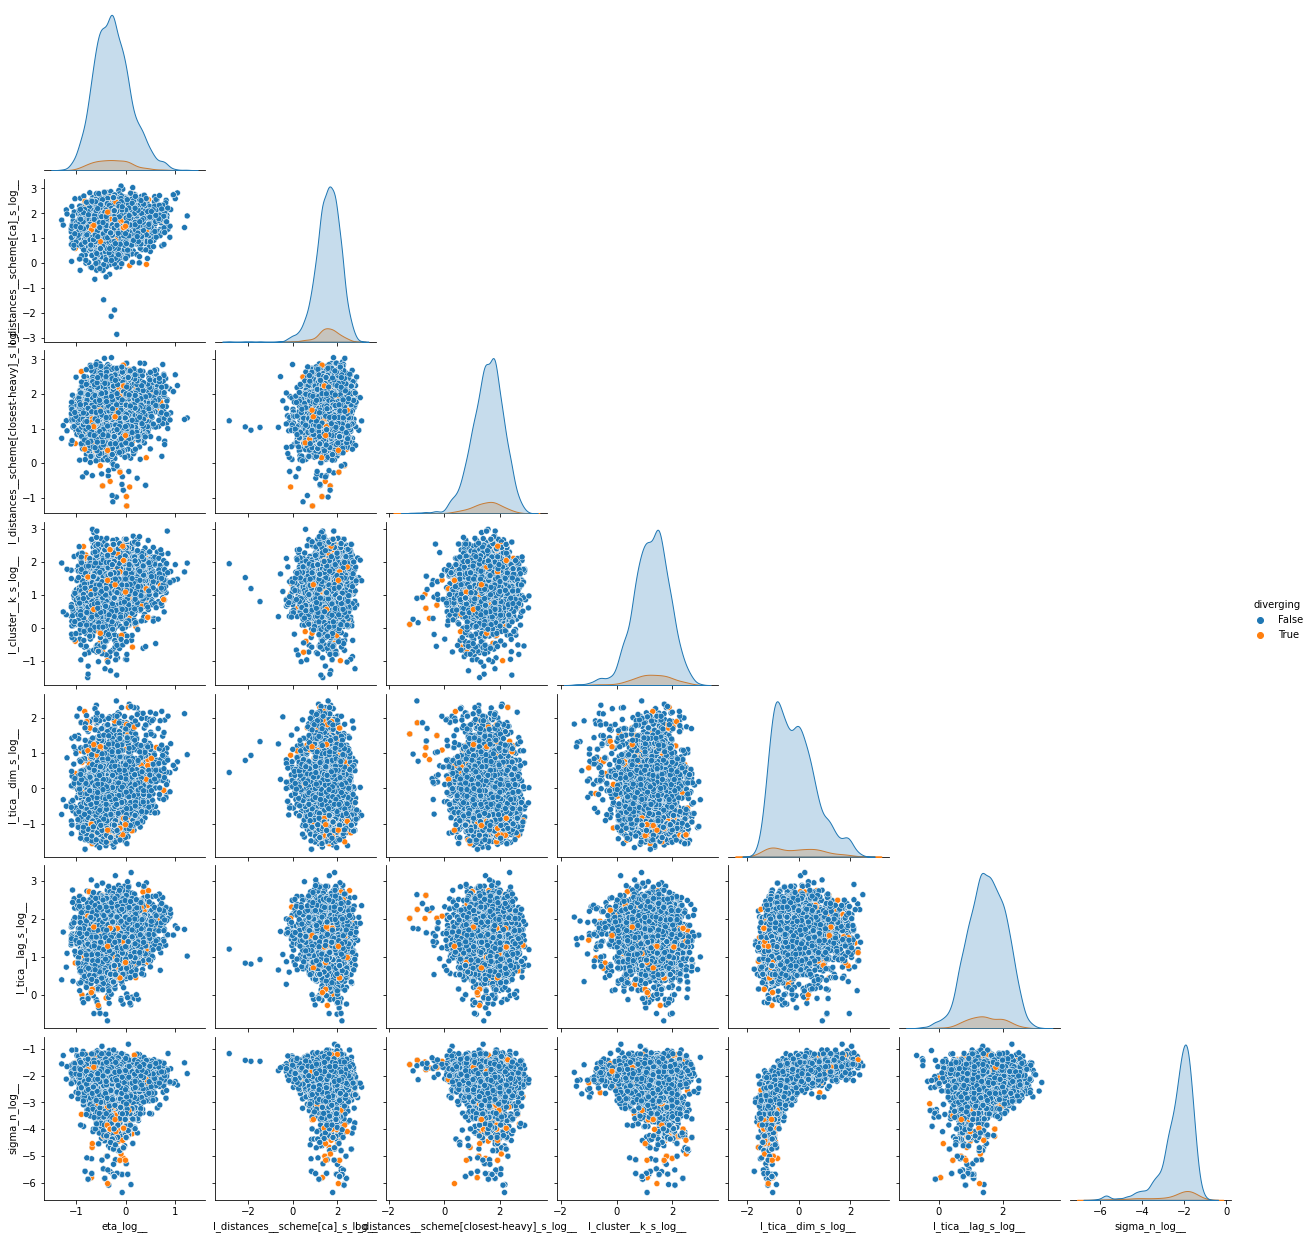

In [49]:
sns.pairplot(to_dataframe(results), hue='diverging', corner=True)

So it does look like the small values of sigma_n are causing the problem. Let's run again with a higher acceptance ratio

In [44]:
pm.summary(results['trace']).round(2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  \
eta                                   0.83  0.34    0.37     1.47       0.01   
l_distances__scheme[ca]_s             5.53  2.82    0.94    10.63       0.08   
l_distances__scheme[closest-heavy]_s  5.44  2.90    1.17    11.16       0.09   
l_cluster__k_s                        4.15  2.59    0.31     8.77       0.12   
l_tica__dim_s                         1.26  1.42    0.18     3.73       0.09   
l_tica__lag_s                         5.25  3.00    0.88    10.73       0.10   
sigma_n                               0.12  0.06    0.00     0.23       0.00   

                                      mcse_sd  ess_mean  ess_sd  ess_bulk  \
eta                                      0.01     761.0   761.0     708.0   
l_distances__scheme[ca]_s                0.06    1111.0  1111.0    1040.0   
l_distances__scheme[closest-heavy]_s     0.06    1123.0  1123.0     853.0   
l_cluster__k_s                           0.08     462.0   462.0     555.0   
l_tica__dim_s                            0.06     266.0   266.0     299.0   
l_tica__lag_s                            0.07     889.0   889.0     729.0   
sigma_n                                  0.00     293.0   293.0     255.0   

                                      ess_tail  r_hat  
eta                                     1280.0   1.01  
l_distances__scheme[ca]_s               1374.0   1.00  
l_distances__scheme[closest-heavy]_s     700.0   1.01  
l_cluster__k_s                           615.0   1.00  
l_tica__dim_s                            289.0   1.01  
l_tica__lag_s                           1008.0   1.01  
sigma_n                                  136.0   1.02

In [46]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

feature = 'distances'
feature_label = 'distances_linear'
transform = 'linear'
ind_vars = ['cluster__k', 'tica__dim', 'tica__lag', 'distances__scheme']
input_space = {'tica__lag': np.array([1, 10, 100]), 'tica__dim': np.array([1, 5, 10]), 'cluster__k': np.array([10, 250, 500]), 
              'distances__scheme': np.array(['ca', 'closest-heavy'])}


dep_var=list(results['data'].columns)[0]
ind_vars = list(results['data'].columns)[1:]

formula = f"{dep_var} ~ 0 + " + ' + '.join(ind_vars)
new_results = fit(results['data'], dep_var, ind_vars, formula, input_space, bayes_kws=dict(draws=1000, tune=2000, chains=4, cores=4, target_accept=0.99))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_n, l_tica__lag_s, l_tica__dim_s, l_cluster__k_s, l_distances__scheme[closest-heavy]_s, l_distances__scheme[ca]_s, eta]


INFO (theano.gof.compilelock): Waiting for existing lock by process '6384' (I am process '6326')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/robertarbon/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.0-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '6353' (I am process '6326')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/robertarbon/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.0-64/lock_dir
/Users/robertarbon/opt/miniconda3/envs/msmsense/lib/python3.8/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/robertarbon/opt/miniconda3/envs/msmsense/lib/python3.8/site-packages/theano

In [47]:
pm.summary(new_results['trace']).round(2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  \
eta                                   0.85  0.36    0.35     1.46       0.01   
l_distances__scheme[ca]_s             5.60  2.86    1.02    10.72       0.06   
l_distances__scheme[closest-heavy]_s  5.66  3.00    1.18    11.41       0.06   
l_cluster__k_s                        4.21  2.66    0.22     8.85       0.05   
l_tica__dim_s                         1.18  1.32    0.15     3.47       0.03   
l_tica__lag_s                         5.22  2.97    1.14    10.63       0.06   
sigma_n                               0.12  0.07    0.00     0.22       0.00   

                                      mcse_sd  ess_mean  ess_sd  ess_bulk  \
eta                                      0.01    1994.0  1895.0    2441.0   
l_distances__scheme[ca]_s                0.04    2731.0  2676.0    2481.0   
l_distances__scheme[closest-heavy]_s     0.04    2833.0  2645.0    2681.0   
l_cluster__k_s                           0.03    2972.0  2972.0    2610.0   
l_tica__dim_s                            0.02    1656.0  1656.0    1161.0   
l_tica__lag_s                            0.04    2740.0  2702.0    2564.0   
sigma_n                                  0.00    1140.0  1140.0     998.0   

                                      ess_tail  r_hat  
eta                                     1926.0   1.00  
l_distances__scheme[ca]_s               2286.0   1.00  
l_distances__scheme[closest-heavy]_s    2330.0   1.00  
l_cluster__k_s                          2076.0   1.00  
l_tica__dim_s                           2192.0   1.01  
l_tica__lag_s                           2643.0   1.00  
sigma_n                                  753.0   1.01

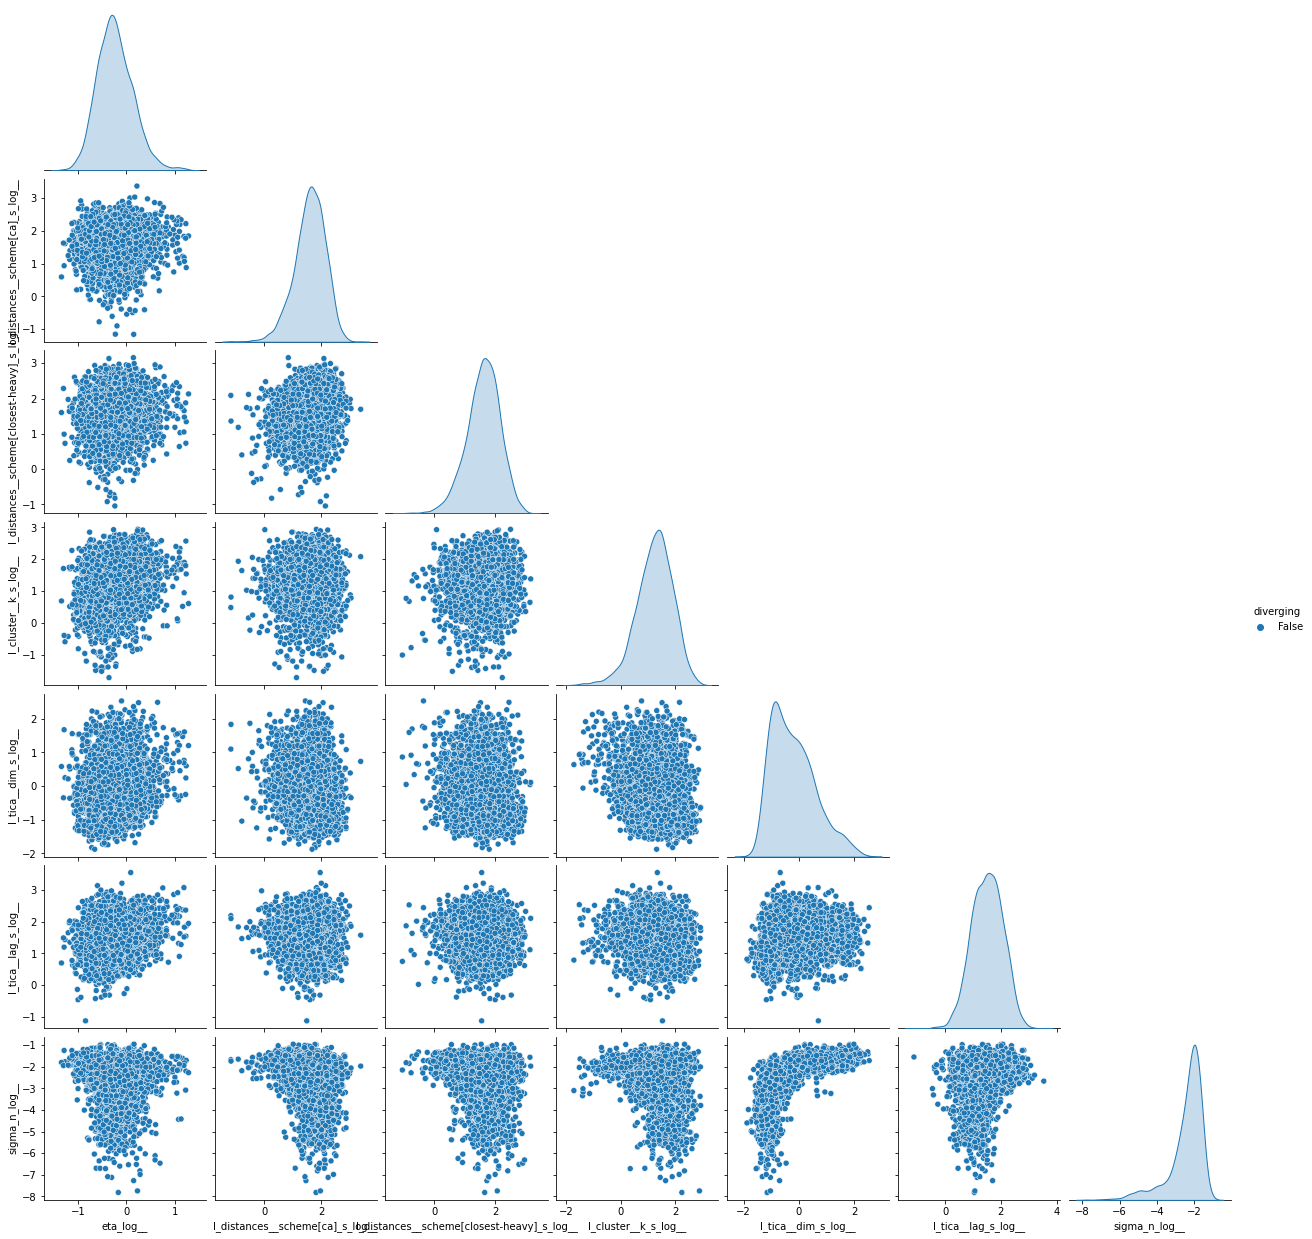

In [50]:
sns.pairplot(to_dataframe(new_results), hue='diverging', corner=True)

array([[<AxesSubplot:title={'center':'eta\n0'}>,
        <AxesSubplot:title={'center':'eta\n1'}>,
        <AxesSubplot:title={'center':'eta\n2'}>,
        <AxesSubplot:title={'center':'eta\n3'}>],
       [<AxesSubplot:title={'center':'l_distances__scheme[ca]_s\n0'}>,
        <AxesSubplot:title={'center':'l_distances__scheme[ca]_s\n1'}>,
        <AxesSubplot:title={'center':'l_distances__scheme[ca]_s\n2'}>,
        <AxesSubplot:title={'center':'l_distances__scheme[ca]_s\n3'}>],
       [<AxesSubplot:title={'center':'l_distances__scheme[closest-heavy]_s\n0'}>,
        <AxesSubplot:title={'center':'l_distances__scheme[closest-heavy]_s\n1'}>,
        <AxesSubplot:title={'center':'l_distances__scheme[closest-heavy]_s\n2'}>,
        <AxesSubplot:title={'center':'l_distances__scheme[closest-heavy]_s\n3'}>],
       [<AxesSubplot:title={'center':'l_cluster__k_s\n0'}>,
        <AxesSubplot:title={'center':'l_cluster__k_s\n1'}>,
        <AxesSubplot:title={'center':'l_cluster__k_s\n2'}>,
        <

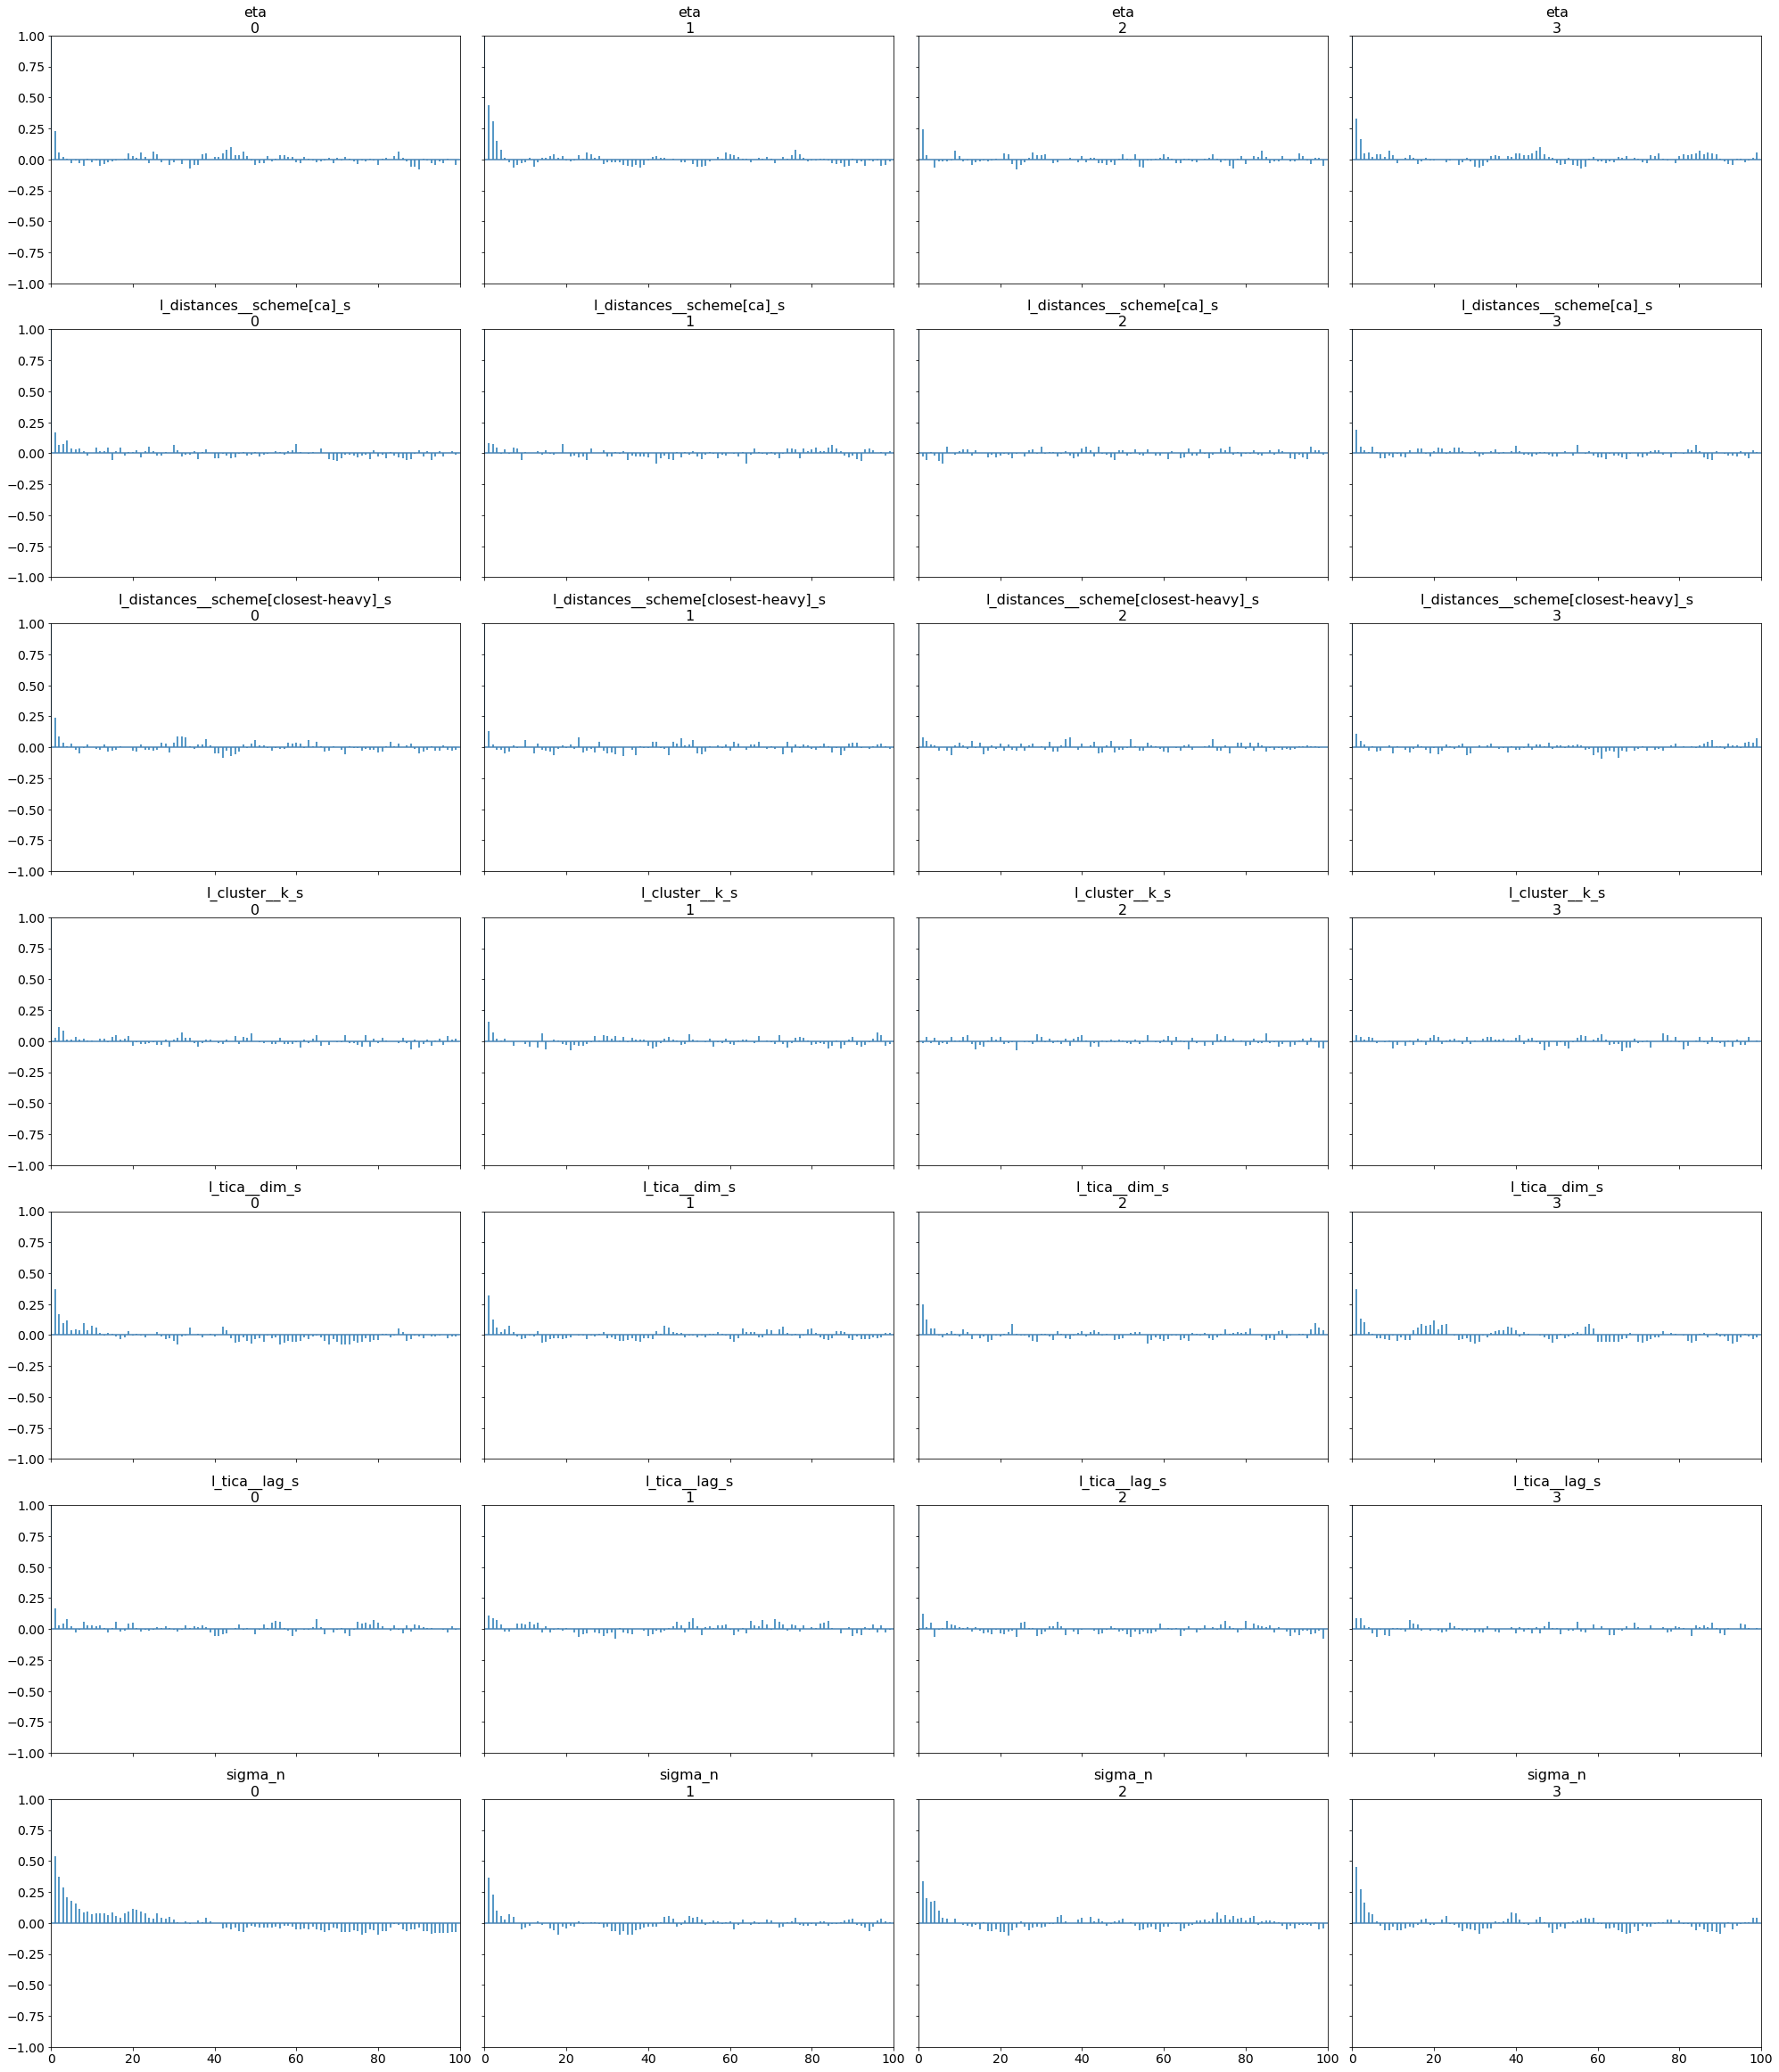

In [51]:
pm.plots.plot_autocorr(new_results['trace'])

We can see that there's no divergencies and much smaller values of sigma_n are being explored. this is good.  However there is still autocorrelation in the noise term which is bad. 


In [54]:
new_results_2 = fit(results['data'], dep_var, ind_vars, formula, input_space, bayes_kws=dict(draws=5000, tune=2000, chains=4, cores=4, target_accept=0.95))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_n, l_tica__lag_s, l_tica__dim_s, l_cluster__k_s, l_distances__scheme[closest-heavy]_s, l_distances__scheme[ca]_s, eta]


INFO (theano.gof.compilelock): Waiting for existing lock by process '7107' (I am process '7164')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/robertarbon/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.0-64/lock_dir
/Users/robertarbon/opt/miniconda3/envs/msmsense/lib/python3.8/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/robertarbon/opt/miniconda3/envs/msmsense/lib/python3.8/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result eit

In [55]:
pm.summary(new_results_2['trace']).round(2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  \
eta                                   0.84  0.35    0.35     1.44       0.00   
l_distances__scheme[ca]_s             5.72  2.98    0.92    11.11       0.02   
l_distances__scheme[closest-heavy]_s  5.65  2.98    1.08    11.39       0.02   
l_cluster__k_s                        4.20  2.63    0.30     8.97       0.02   
l_tica__dim_s                         1.18  1.36    0.17     3.47       0.02   
l_tica__lag_s                         5.17  3.00    1.01    10.81       0.03   
sigma_n                               0.11  0.06    0.00     0.22       0.00   

                                      mcse_sd  ess_mean   ess_sd  ess_bulk  \
eta                                      0.00   10535.0   9623.0   13202.0   
l_distances__scheme[ca]_s                0.02   14917.0  14817.0   13307.0   
l_distances__scheme[closest-heavy]_s     0.02   16351.0  16312.0   14020.0   
l_cluster__k_s                           0.02   10686.0  10686.0    9580.0   
l_tica__dim_s                            0.01    7715.0   7715.0    5176.0   
l_tica__lag_s                            0.02   10933.0  10933.0    9892.0   
sigma_n                                  0.00    4993.0   4993.0    4225.0   

                                      ess_tail  r_hat  
eta                                    11246.0    1.0  
l_distances__scheme[ca]_s              11040.0    1.0  
l_distances__scheme[closest-heavy]_s    9929.0    1.0  
l_cluster__k_s                          8298.0    1.0  
l_tica__dim_s                          10652.0    1.0  
l_tica__lag_s                          13722.0    1.0  
sigma_n                                 2918.0    1.0

array([[<AxesSubplot:title={'center':'eta'}>,
        <AxesSubplot:title={'center':'eta'}>],
       [<AxesSubplot:title={'center':'l_distances__scheme[ca]_s'}>,
        <AxesSubplot:title={'center':'l_distances__scheme[ca]_s'}>],
       [<AxesSubplot:title={'center':'l_distances__scheme[closest-heavy]_s'}>,
        <AxesSubplot:title={'center':'l_distances__scheme[closest-heavy]_s'}>],
       [<AxesSubplot:title={'center':'l_cluster__k_s'}>,
        <AxesSubplot:title={'center':'l_cluster__k_s'}>],
       [<AxesSubplot:title={'center':'l_tica__dim_s'}>,
        <AxesSubplot:title={'center':'l_tica__dim_s'}>],
       [<AxesSubplot:title={'center':'l_tica__lag_s'}>,
        <AxesSubplot:title={'center':'l_tica__lag_s'}>],
       [<AxesSubplot:title={'center':'sigma_n'}>,
        <AxesSubplot:title={'center':'sigma_n'}>]], dtype=object)

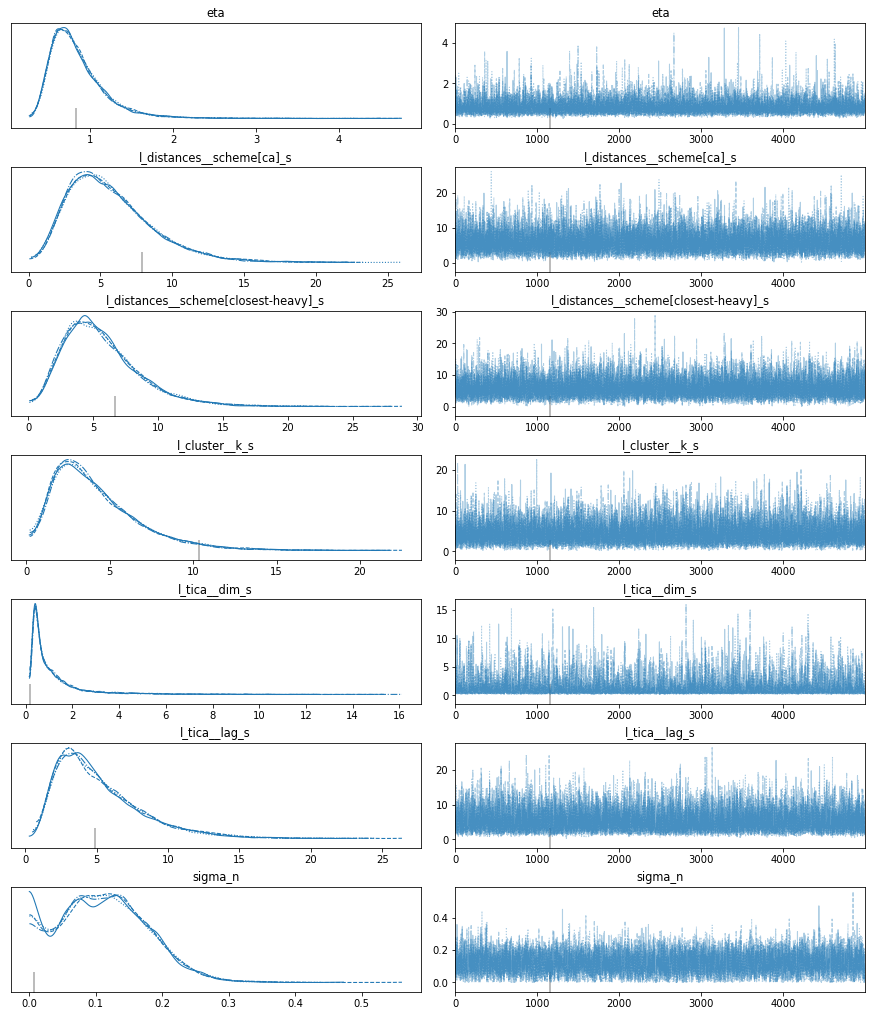

In [57]:
pm.plots.plot_trace(new_results_2['trace'])

Clearly the error term is mis-specified here. 

In [62]:

data = results['data']

kernel_type='m52'


bayes_kws=dict(draws=10000, tune=2000, chains=4, cores=4, target_accept=0.99)

dep_range = np.array([data[dep_var].min(), data[dep_var].max()])    
output_space = {'dep_var': dep_range}
var_space = input_space.copy()
var_space.update({dep_var: output_space['dep_var']})

# Create scaler
vs = funcs.create_grid(var_space)
vs_y, vs_X = funcs.create_dmatrices(vs, formula=formula)
_, scaler = funcs.scale_dmatrix(pd.concat([vs_y, vs_X], axis=1), scaler=None)

# Scale data
y, X = funcs.create_dmatrices(data, formula=formula)
data_s, _ = funcs.scale_dmatrix(pd.concat([y, X], axis=1), scaler=scaler)
# GP data and priors
dep_var_cols = [x for x in data_s.columns if dep_var in x]
ind_var_cols = [x for x in data_s.columns if np.any([y in x for y in ind_vars])]
y = data_s.loc[:, dep_var_cols]
X =  data_s.loc[:, ind_var_cols]

l_prior = funcs.gamma(2, 0.5)
eta_prior = funcs.hcauchy(2)
sigma_prior = funcs.hcauchy(2)
    


with pm.Model() as model:
    # Covert arrays
    X_a = X.values
    y_a = y.values.flatten()
    X_cols = list(X.columns)


    # Kernels
    # 3 way interaction
    eta = eta_prior('eta')
    cov = eta**2
    for i in range(X_a.shape[1]):
        var_lab = 'l_'+X_cols[i]
        if kernel_type=='rbf':
            cov = cov*pm.gp.cov.ExpQuad(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
        if kernel_type=='exponential':
            cov = cov*pm.gp.cov.Exponential(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
        if kernel_type=='m52':
            cov = cov*pm.gp.cov.Matern52(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
        if kernel_type=='m32':
            cov = cov*pm.gp.cov.Matern32(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])

    # Covariance model
    cov_tot = cov 

    # Noise model
    sigma_n =sigma_prior('sigma_n')


    gp = pm.gp.Marginal(cov_func=cov_tot)
    y_ = gp.marginal_likelihood('y_', X=X_a, y=y_a, noise=sigma_n)


    trace = pm.sample(**bayes_kws)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_n, l_tica__lag_s, l_tica__dim_s, l_cluster__k_s, l_distances__scheme[closest-heavy]_s, l_distances__scheme[ca]_s, eta]


INFO (theano.gof.compilelock): Waiting for existing lock by process '10998' (I am process '11027')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/robertarbon/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.0-64/lock_dir
/Users/robertarbon/opt/miniconda3/envs/msmsense/lib/python3.8/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/robertarbon/opt/miniconda3/envs/msmsense/lib/python3.8/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result e

array([[<AxesSubplot:title={'center':'eta'}>,
        <AxesSubplot:title={'center':'eta'}>],
       [<AxesSubplot:title={'center':'l_distances__scheme[ca]_s'}>,
        <AxesSubplot:title={'center':'l_distances__scheme[ca]_s'}>],
       [<AxesSubplot:title={'center':'l_distances__scheme[closest-heavy]_s'}>,
        <AxesSubplot:title={'center':'l_distances__scheme[closest-heavy]_s'}>],
       [<AxesSubplot:title={'center':'l_cluster__k_s'}>,
        <AxesSubplot:title={'center':'l_cluster__k_s'}>],
       [<AxesSubplot:title={'center':'l_tica__dim_s'}>,
        <AxesSubplot:title={'center':'l_tica__dim_s'}>],
       [<AxesSubplot:title={'center':'l_tica__lag_s'}>,
        <AxesSubplot:title={'center':'l_tica__lag_s'}>],
       [<AxesSubplot:title={'center':'sigma_n'}>,
        <AxesSubplot:title={'center':'sigma_n'}>]], dtype=object)

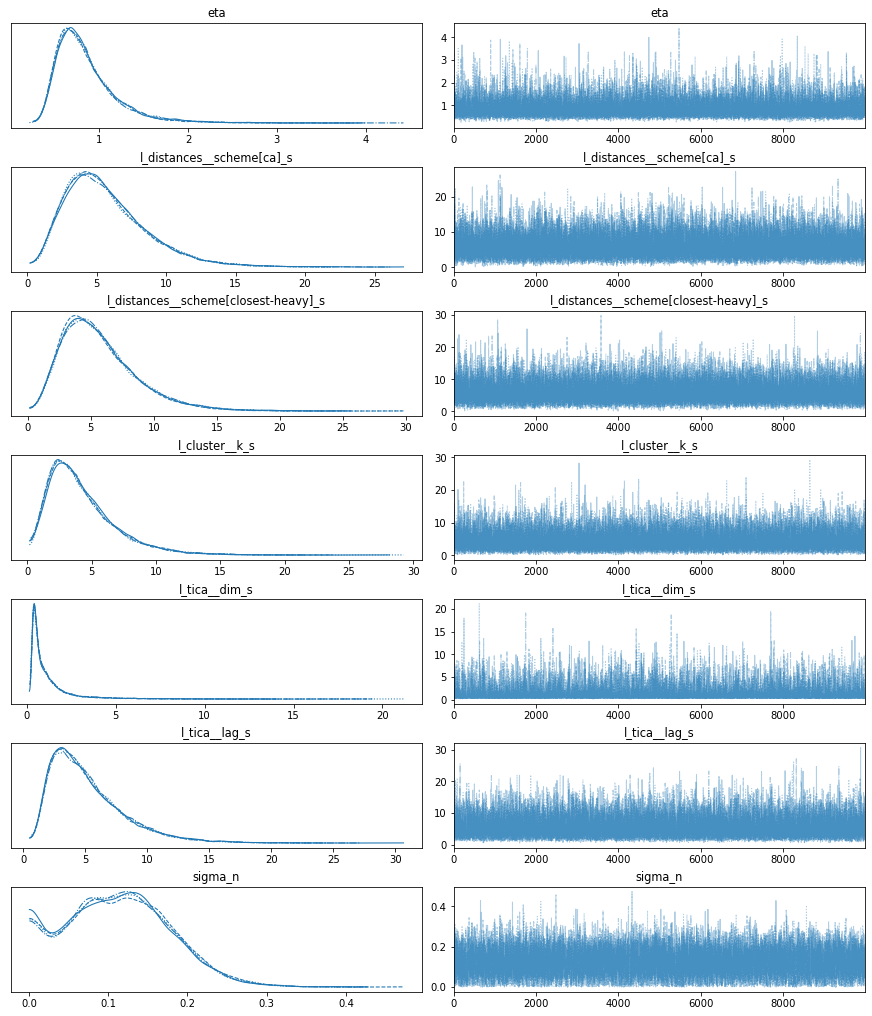

In [63]:
pm.plots.plot_trace(trace)

In [64]:
pm.summary(trace)

mean     sd  hdi_3%  hdi_97%  \
eta                                   0.849  0.352   0.352    1.468   
l_distances__scheme[ca]_s             5.670  2.974   0.938   11.097   
l_distances__scheme[closest-heavy]_s  5.673  2.991   0.876   11.086   
l_cluster__k_s                        4.222  2.638   0.353    9.046   
l_tica__dim_s                         1.167  1.325   0.177    3.357   
l_tica__lag_s                         5.158  2.980   1.054   10.680   
sigma_n                               0.114  0.064   0.000    0.216   

                                      mcse_mean  mcse_sd  ess_mean   ess_sd  \
eta                                       0.002    0.002   20706.0  19038.0   
l_distances__scheme[ca]_s                 0.016    0.012   32977.0  32977.0   
l_distances__scheme[closest-heavy]_s      0.017    0.012   32791.0  32071.0   
l_cluster__k_s                            0.018    0.013   20745.0  20745.0   
l_tica__dim_s                             0.011    0.007   15613.0  15613.0   
l_tica__lag_s                             0.021    0.015   20481.0  20481.0   
sigma_n                                   0.001    0.000    8709.0   8709.0   

                                      ess_bulk  ess_tail  r_hat  
eta                                    25513.0   21635.0    1.0  
l_distances__scheme[ca]_s              28528.0   22192.0    1.0  
l_distances__scheme[closest-heavy]_s   28595.0   21240.0    1.0  
l_cluster__k_s                         18346.0   17430.0    1.0  
l_tica__dim_s                           9440.0   17835.0    1.0  
l_tica__lag_s                          18558.0   27143.0    1.0  
sigma_n                                 7741.0    6904.0    1.0

In [65]:
pm.summary(new_results['trace'])

mean     sd  hdi_3%  hdi_97%  \
eta                                   0.848  0.363   0.354    1.463   
l_distances__scheme[ca]_s             5.601  2.855   1.025   10.717   
l_distances__scheme[closest-heavy]_s  5.661  2.996   1.178   11.414   
l_cluster__k_s                        4.213  2.657   0.220    8.845   
l_tica__dim_s                         1.179  1.320   0.153    3.473   
l_tica__lag_s                         5.225  2.972   1.135   10.626   
sigma_n                               0.115  0.066   0.001    0.221   

                                      mcse_mean  mcse_sd  ess_mean  ess_sd  \
eta                                       0.008    0.006    1994.0  1895.0   
l_distances__scheme[ca]_s                 0.055    0.039    2731.0  2676.0   
l_distances__scheme[closest-heavy]_s      0.056    0.041    2833.0  2645.0   
l_cluster__k_s                            0.049    0.034    2972.0  2972.0   
l_tica__dim_s                             0.032    0.023    1656.0  1656.0   
l_tica__lag_s                             0.057    0.040    2740.0  2702.0   
sigma_n                                   0.002    0.001    1140.0  1140.0   

                                      ess_bulk  ess_tail  r_hat  
eta                                     2441.0    1926.0   1.00  
l_distances__scheme[ca]_s               2481.0    2286.0   1.00  
l_distances__scheme[closest-heavy]_s    2681.0    2330.0   1.00  
l_cluster__k_s                          2610.0    2076.0   1.00  
l_tica__dim_s                           1161.0    2192.0   1.01  
l_tica__lag_s                           2564.0    2643.0   1.00  
sigma_n                                  998.0     753.0   1.01

Let's try the exponential kernel.  

In [66]:

data = results['data']

kernel_type='exponential'


bayes_kws=dict(draws=1000, tune=2000, chains=4, cores=4, target_accept=0.99)

dep_range = np.array([data[dep_var].min(), data[dep_var].max()])    
output_space = {'dep_var': dep_range}
var_space = input_space.copy()
var_space.update({dep_var: output_space['dep_var']})

# Create scaler
vs = funcs.create_grid(var_space)
vs_y, vs_X = funcs.create_dmatrices(vs, formula=formula)
_, scaler = funcs.scale_dmatrix(pd.concat([vs_y, vs_X], axis=1), scaler=None)

# Scale data
y, X = funcs.create_dmatrices(data, formula=formula)
data_s, _ = funcs.scale_dmatrix(pd.concat([y, X], axis=1), scaler=scaler)
# GP data and priors
dep_var_cols = [x for x in data_s.columns if dep_var in x]
ind_var_cols = [x for x in data_s.columns if np.any([y in x for y in ind_vars])]
y = data_s.loc[:, dep_var_cols]
X =  data_s.loc[:, ind_var_cols]

l_prior = funcs.gamma(2, 0.5)
eta_prior = funcs.hcauchy(2)
sigma_prior = funcs.hcauchy(2)
    


with pm.Model() as model:
    # Covert arrays
    X_a = X.values
    y_a = y.values.flatten()
    X_cols = list(X.columns)


    # Kernels
    # 3 way interaction
    eta = eta_prior('eta')
    cov = eta**2
    for i in range(X_a.shape[1]):
        var_lab = 'l_'+X_cols[i]
        if kernel_type=='rbf':
            cov = cov*pm.gp.cov.ExpQuad(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
        if kernel_type=='exponential':
            cov = cov*pm.gp.cov.Exponential(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
        if kernel_type=='m52':
            cov = cov*pm.gp.cov.Matern52(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
        if kernel_type=='m32':
            cov = cov*pm.gp.cov.Matern32(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])

    # Covariance model
    cov_tot = cov 

    # Noise model
    sigma_n =sigma_prior('sigma_n')


    gp = pm.gp.Marginal(cov_func=cov_tot)
    y_ = gp.marginal_likelihood('y_', X=X_a, y=y_a, noise=sigma_n)


    trace = pm.sample(**bayes_kws)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_n, l_tica__lag_s, l_tica__dim_s, l_cluster__k_s, l_distances__scheme[closest-heavy]_s, l_distances__scheme[ca]_s, eta]


INFO (theano.gof.compilelock): Waiting for existing lock by process '11327' (I am process '11268')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/robertarbon/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.0-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '11295' (I am process '11268')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/robertarbon/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.0-64/lock_dir
/Users/robertarbon/opt/miniconda3/envs/msmsense/lib/python3.8/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/robertarbon/opt/miniconda3/envs/msmsense/lib/python3.8/site-packages/th

array([[<AxesSubplot:title={'center':'eta'}>,
        <AxesSubplot:title={'center':'eta'}>],
       [<AxesSubplot:title={'center':'l_distances__scheme[ca]_s'}>,
        <AxesSubplot:title={'center':'l_distances__scheme[ca]_s'}>],
       [<AxesSubplot:title={'center':'l_distances__scheme[closest-heavy]_s'}>,
        <AxesSubplot:title={'center':'l_distances__scheme[closest-heavy]_s'}>],
       [<AxesSubplot:title={'center':'l_cluster__k_s'}>,
        <AxesSubplot:title={'center':'l_cluster__k_s'}>],
       [<AxesSubplot:title={'center':'l_tica__dim_s'}>,
        <AxesSubplot:title={'center':'l_tica__dim_s'}>],
       [<AxesSubplot:title={'center':'l_tica__lag_s'}>,
        <AxesSubplot:title={'center':'l_tica__lag_s'}>],
       [<AxesSubplot:title={'center':'sigma_n'}>,
        <AxesSubplot:title={'center':'sigma_n'}>]], dtype=object)

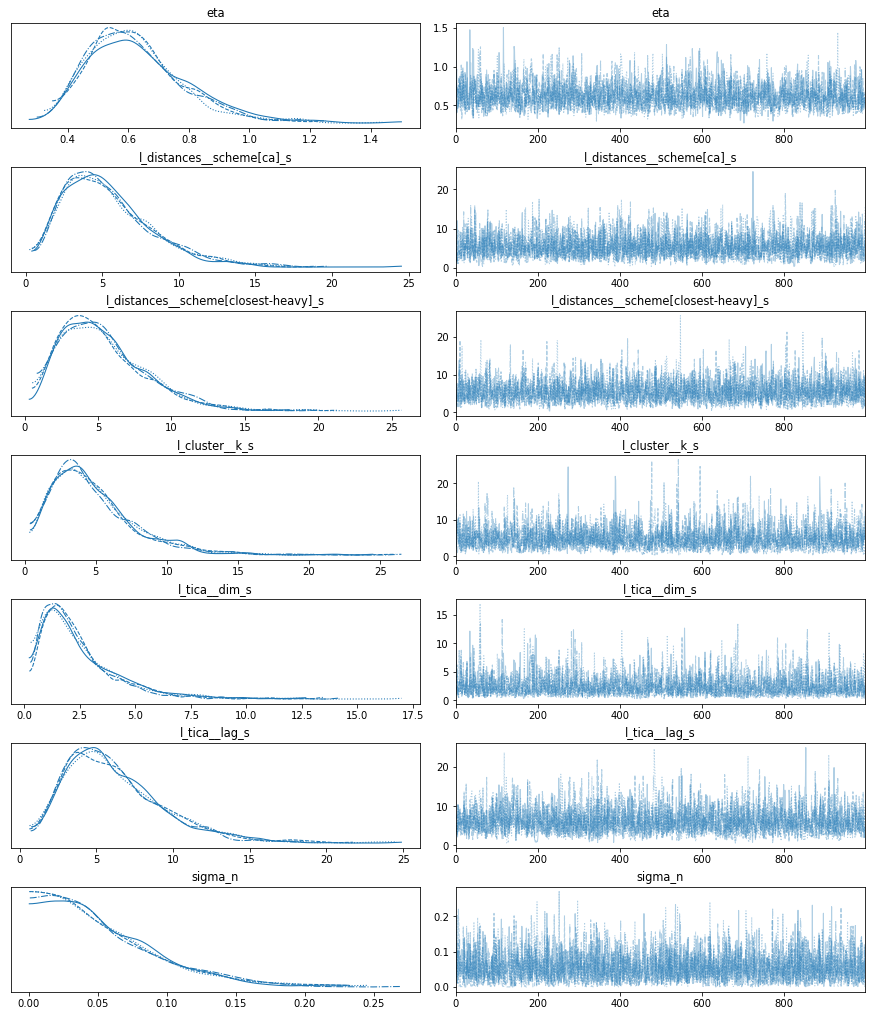

In [67]:
pm.plots.plot_trace(trace)

In [68]:
pm.summary(trace)

mean     sd  hdi_3%  hdi_97%  \
eta                                   0.627  0.160   0.358    0.921   
l_distances__scheme[ca]_s             5.388  2.935   0.739   10.648   
l_distances__scheme[closest-heavy]_s  5.392  2.980   0.773   10.666   
l_cluster__k_s                        4.848  3.051   0.611   10.479   
l_tica__dim_s                         2.463  1.819   0.305    5.653   
l_tica__lag_s                         6.189  3.220   1.483   12.441   
sigma_n                               0.053  0.042   0.000    0.131   

                                      mcse_mean  mcse_sd  ess_mean  ess_sd  \
eta                                       0.003    0.002    2323.0  2261.0   
l_distances__scheme[ca]_s                 0.048    0.035    3682.0  3597.0   
l_distances__scheme[closest-heavy]_s      0.051    0.036    3457.0  3457.0   
l_cluster__k_s                            0.056    0.040    2974.0  2974.0   
l_tica__dim_s                             0.036    0.025    2559.0  2559.0   
l_tica__lag_s                             0.062    0.044    2700.0  2667.0   
sigma_n                                   0.001    0.001    3249.0  3249.0   

                                      ess_bulk  ess_tail  r_hat  
eta                                     2425.0    2314.0    1.0  
l_distances__scheme[ca]_s               3343.0    2518.0    1.0  
l_distances__scheme[closest-heavy]_s    2995.0    2528.0    1.0  
l_cluster__k_s                          2587.0    2055.0    1.0  
l_tica__dim_s                           2584.0    2748.0    1.0  
l_tica__lag_s                           2480.0    1944.0    1.0  
sigma_n                                 2142.0    1241.0    1.0

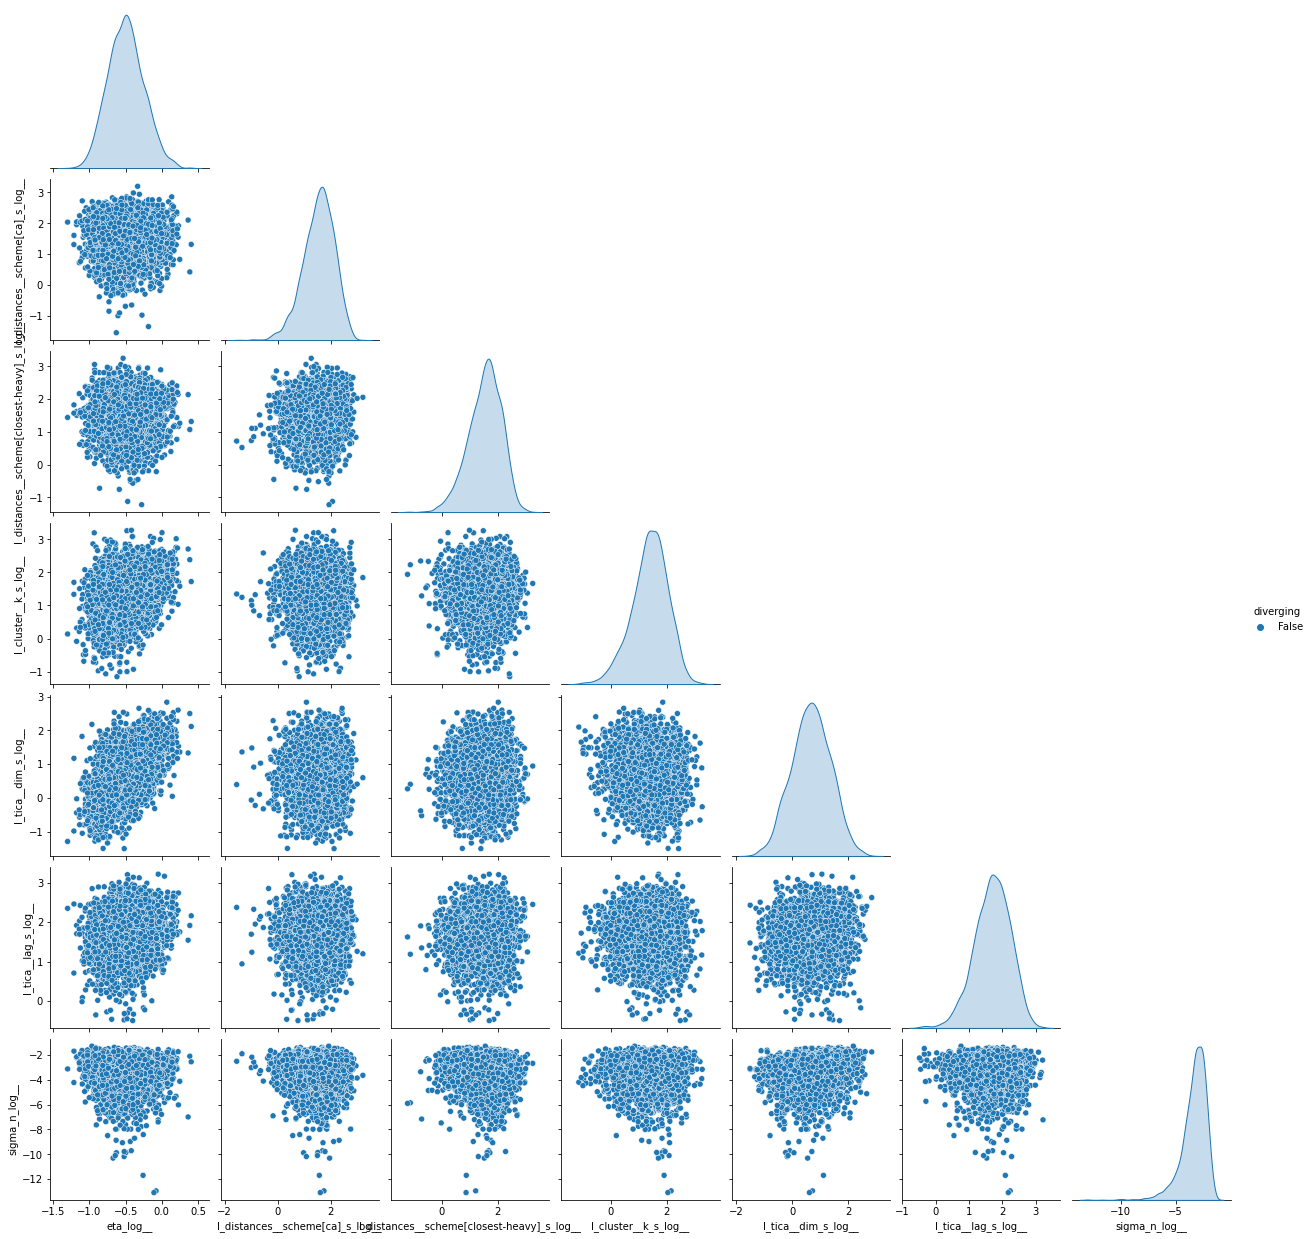

In [69]:
sns.pairplot(to_dataframe({'model': model, 'trace': trace}), hue='diverging', corner=True)

This is much better. Can try reducing the acceptance ratio

In [70]:

data = results['data']

kernel_type='exponential'


bayes_kws=dict(draws=1000, tune=2000, chains=4, cores=4, target_accept=0.90)

dep_range = np.array([data[dep_var].min(), data[dep_var].max()])    
output_space = {'dep_var': dep_range}
var_space = input_space.copy()
var_space.update({dep_var: output_space['dep_var']})

# Create scaler
vs = funcs.create_grid(var_space)
vs_y, vs_X = funcs.create_dmatrices(vs, formula=formula)
_, scaler = funcs.scale_dmatrix(pd.concat([vs_y, vs_X], axis=1), scaler=None)

# Scale data
y, X = funcs.create_dmatrices(data, formula=formula)
data_s, _ = funcs.scale_dmatrix(pd.concat([y, X], axis=1), scaler=scaler)
# GP data and priors
dep_var_cols = [x for x in data_s.columns if dep_var in x]
ind_var_cols = [x for x in data_s.columns if np.any([y in x for y in ind_vars])]
y = data_s.loc[:, dep_var_cols]
X =  data_s.loc[:, ind_var_cols]

l_prior = funcs.gamma(2, 0.5)
eta_prior = funcs.hcauchy(2)
sigma_prior = funcs.hcauchy(2)
    


with pm.Model() as model:
    # Covert arrays
    X_a = X.values
    y_a = y.values.flatten()
    X_cols = list(X.columns)


    # Kernels
    # 3 way interaction
    eta = eta_prior('eta')
    cov = eta**2
    for i in range(X_a.shape[1]):
        var_lab = 'l_'+X_cols[i]
        if kernel_type=='rbf':
            cov = cov*pm.gp.cov.ExpQuad(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
        if kernel_type=='exponential':
            cov = cov*pm.gp.cov.Exponential(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
        if kernel_type=='m52':
            cov = cov*pm.gp.cov.Matern52(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
        if kernel_type=='m32':
            cov = cov*pm.gp.cov.Matern32(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])

    # Covariance model
    cov_tot = cov 

    # Noise model
    sigma_n =sigma_prior('sigma_n')


    gp = pm.gp.Marginal(cov_func=cov_tot)
    y_ = gp.marginal_likelihood('y_', X=X_a, y=y_a, noise=sigma_n)


    trace = pm.sample(**bayes_kws)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_n, l_tica__lag_s, l_tica__dim_s, l_cluster__k_s, l_distances__scheme[closest-heavy]_s, l_distances__scheme[ca]_s, eta]


INFO (theano.gof.compilelock): Waiting for existing lock by process '15238' (I am process '15177')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/robertarbon/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.0-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '15206' (I am process '15177')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/robertarbon/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.0-64/lock_dir
/Users/robertarbon/opt/miniconda3/envs/msmsense/lib/python3.8/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/robertarbon/opt/miniconda3/envs/msmsense/lib/python3.8/site-packages/th

In [71]:
pm.summary(trace)

mean     sd  hdi_3%  hdi_97%  \
eta                                   0.627  0.157   0.373    0.926   
l_distances__scheme[ca]_s             5.407  2.986   0.887   10.915   
l_distances__scheme[closest-heavy]_s  5.411  3.073   0.906   10.981   
l_cluster__k_s                        4.852  2.916   0.477   10.067   
l_tica__dim_s                         2.446  1.788   0.337    5.768   
l_tica__lag_s                         6.190  3.218   1.173   11.998   
sigma_n                               0.053  0.044   0.000    0.135   

                                      mcse_mean  mcse_sd  ess_mean  ess_sd  \
eta                                       0.003    0.002    2838.0  2802.0   
l_distances__scheme[ca]_s                 0.046    0.033    4268.0  4079.0   
l_distances__scheme[closest-heavy]_s      0.043    0.034    5006.0  3967.0   
l_cluster__k_s                            0.043    0.032    4681.0  4212.0   
l_tica__dim_s                             0.034    0.024    2820.0  2820.0   
l_tica__lag_s                             0.050    0.037    4212.0  3819.0   
sigma_n                                   0.001    0.001    4005.0  2954.0   

                                      ess_bulk  ess_tail  r_hat  
eta                                     2911.0    3402.0    1.0  
l_distances__scheme[ca]_s               3856.0    2518.0    1.0  
l_distances__scheme[closest-heavy]_s    4674.0    2238.0    1.0  
l_cluster__k_s                          4209.0    2543.0    1.0  
l_tica__dim_s                           2915.0    3125.0    1.0  
l_tica__lag_s                           4013.0    2815.0    1.0  
sigma_n                                 3079.0    2026.0    1.0